In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras.optimizers import Adam
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
import imgaug as ia
from imgaug import augmenters as iaa
from keras.utils import to_categorical
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from warnings import filterwarnings
filterwarnings(action='ignore', category= FutureWarning)
from sklearn.model_selection import train_test_split

In [2]:
images = glob.glob('Data/*/*/CameraRGB/*')
masks = glob.glob("Data/*/*/CameraSeg/*")

In [3]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, train_size=0.9)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5)

In [4]:
def load_data(img_path, mask_path):
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (512, 512))
    
    return img, mask

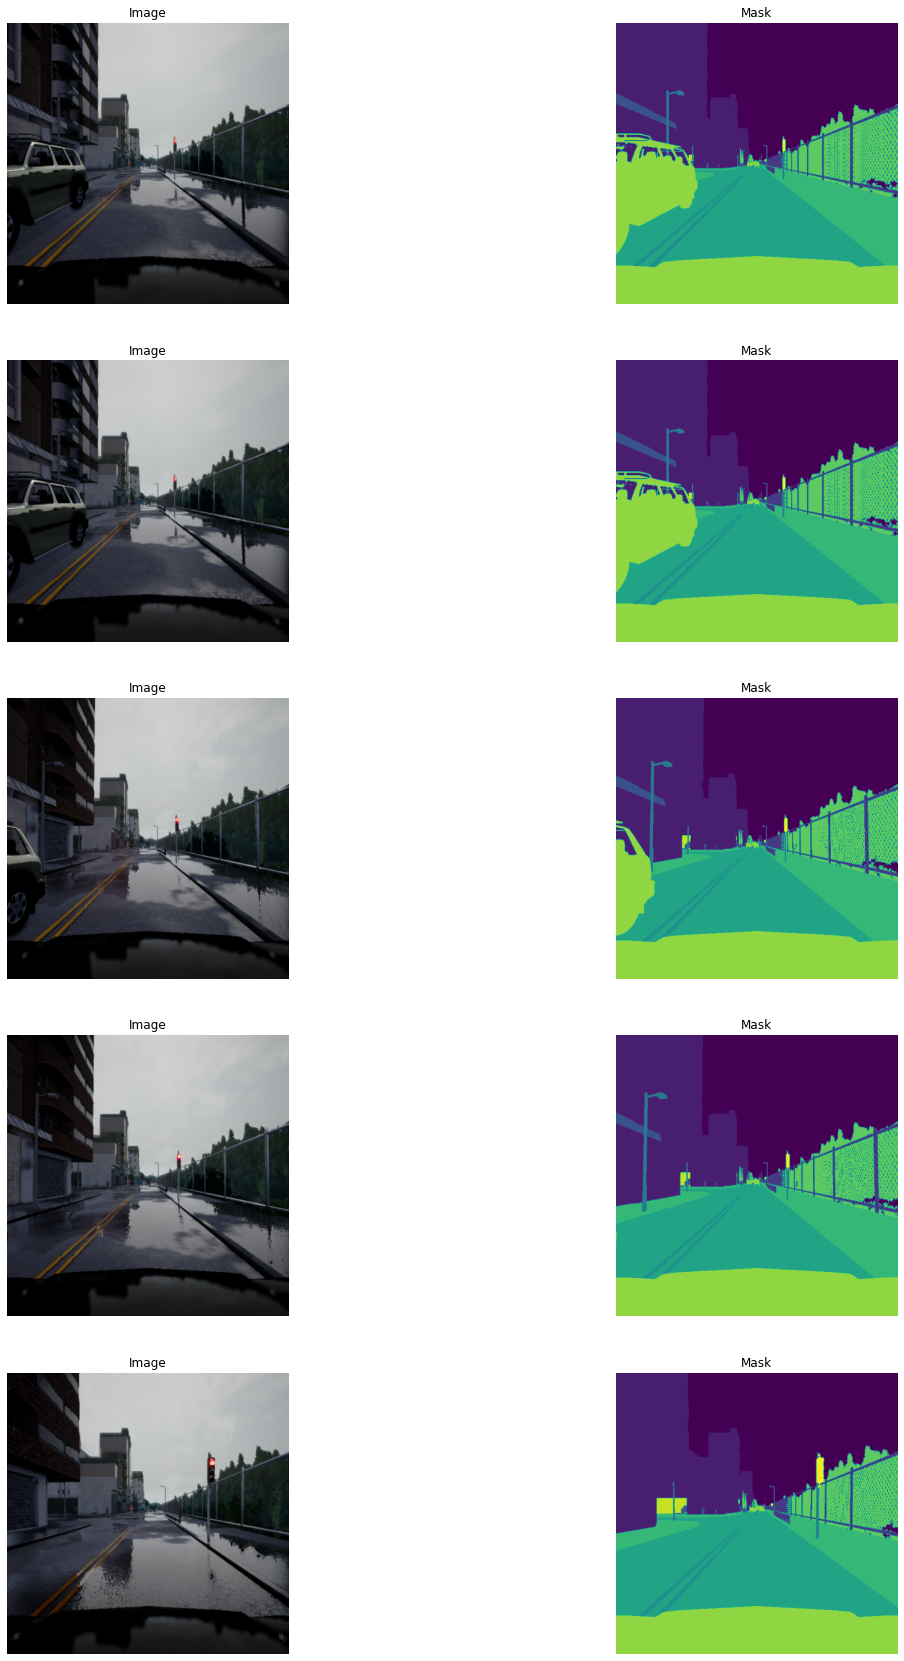

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))

for i, ax in enumerate(axes):

    img, mask = load_data(images[i], masks[i])
    
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].axis('off')
    
    ax[1].imshow(mask[:, :, 0])
    ax[1].set_title('Mask')
    ax[1].axis('off')
    
    

plt.show()


In [6]:
image, mask = load_data(images[10], masks[10])

In [7]:
mask = tf.math.reduce_max(mask, axis=-1)

In [8]:
to_categorical(mask).shape

(512, 512, 13)

In [9]:
seq = iaa.Sequential([
    # iaa.Dropout([0.05, 0.2]),      
    iaa.Sharpen((0.0, 1.0)),       
    iaa.Affine(rotate=(-45, 45)),  
    # iaa.ElasticTransformation(alpha=50, sigma=5)  
], random_order=True)


segmap = SegmentationMapsOnImage(np.array(mask), shape= image.shape)


images_aug_i, segmaps_aug_i = seq(image=image, segmentation_maps=segmap)

mask = segmaps_aug_i.get_arr()

mask = to_categorical(mask, num_classes=13)


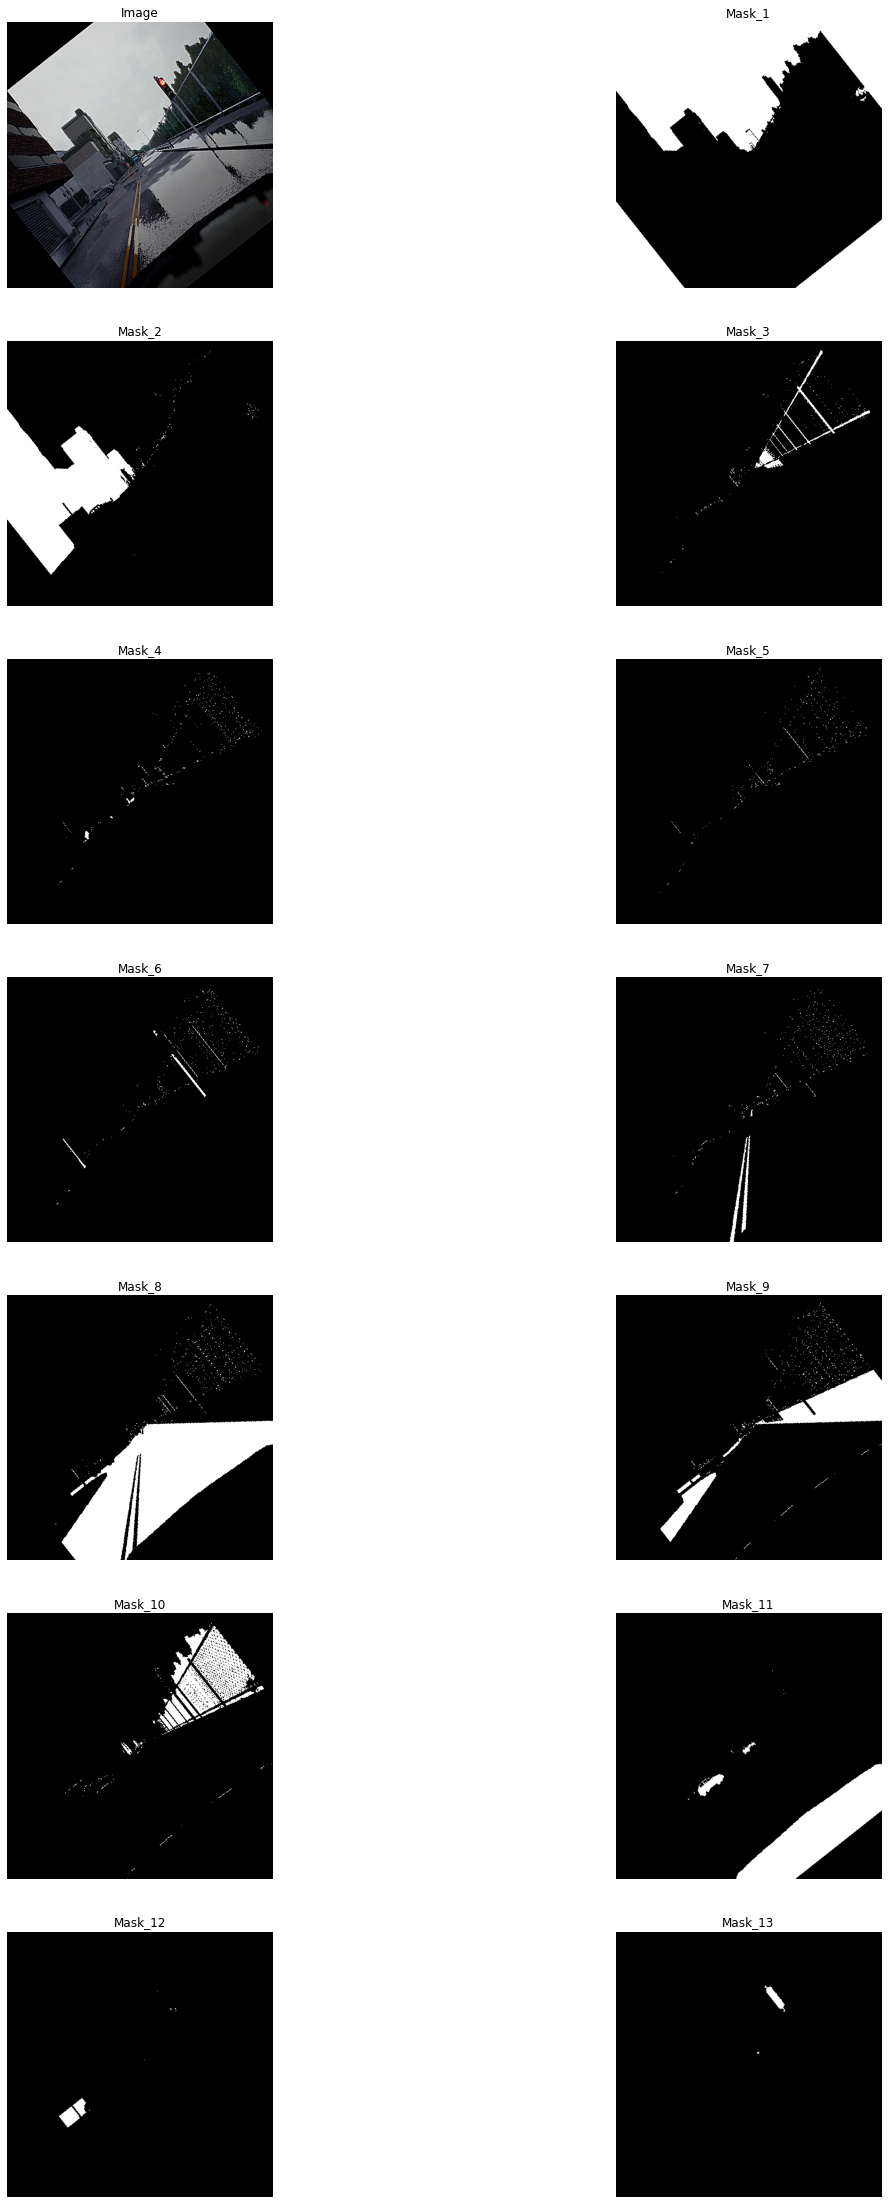

In [10]:
plt.figure(figsize=(20, 40))

plt.subplot(7, 2, 1)
plt.title('Image')
plt.imshow(images_aug_i)
plt.axis('off')

for i in range(13):
    plt.subplot(7, 2, i + 2)  
    plt.title(f'Mask_{i+1}')
    plt.imshow(mask[:, :, i], cmap='gray')
    plt.axis('off')

plt.show()

In [11]:
segmaps_aug_i.shape

(512, 512, 3)

In [12]:
seq = iaa.Sequential([
            # iaa.Dropout([0.05, 0.2]),      
            iaa.Sharpen((0.0, 1.0)),       
            iaa.Affine(rotate=(-45, 45)),  
            # iaa.ElasticTransformation(alpha=50, sigma=5)  
        ], random_order=True)

class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_path, annot_path, batch_size=2, shuffle=False, augmetation= True):
        self.image_path = image_path
        self.annot_path = annot_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmetation = augmetation
        self.on_epoch_end()
       
    def __len__(self):
        return int(np.floor(len(self.image_path) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_path = [self.image_path[k] for k in indexes]
        annot_path = [self.annot_path[k] for k in indexes]
        
        X, y = self.__data_generation(image_path, annot_path)
        
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_path))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
        
    def process(self, image_path, label_path):
        
        image = image_path
        label = label_path
    
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        
        mask = cv2.imread(label)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (512, 512))
        mask = tf.math.reduce_max(mask, axis=-1)
        
        if self.augmetation:

            segmap = SegmentationMapsOnImage(np.array(mask), shape= img.shape)


            images_aug_i, segmaps_aug_i = seq(image=img, segmentation_maps=segmap)

            aug_mask = to_categorical(segmaps_aug_i.get_arr(), num_classes=13)

            return images_aug_i, aug_mask
        
        else:
            mask = to_categorical(mask, num_classes=13)
            return img, mask
    
    
    def __data_generation(self, image_paths, annot_paths):
        X = np.empty((self.batch_size, 512, 512, 3), dtype=np.float32)
        Y = np.empty((self.batch_size, 512, 512, 13),  dtype=np.float32)

        for i, (im_path, annot_path) in enumerate(zip(image_paths, annot_paths)):
            im, mask = self.process(im_path, annot_path)
            X[i,] = im.astype(np.float32) / 255
            Y[i,] = mask
            
        return X, Y

In [13]:
x, y = DataGenerator(x_train, y_train, augmetation=True).__getitem__(1)

In [14]:
x.shape, y.shape

((2, 512, 512, 3), (2, 512, 512, 13))

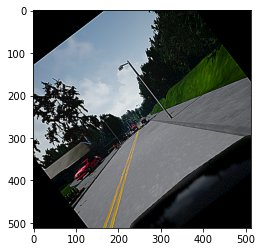

In [15]:
plt.imshow(x[0])

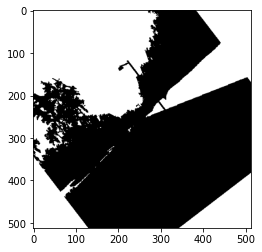

In [16]:
plt.imshow(y[0][:, :, 0], cmap= 'gray')

In [17]:
def unet(input_tensor):

    inputs = Input(input_tensor)

    x = Conv2D(64, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    s1 = Activation("relu")(x)

    p1 = MaxPooling2D((2, 2))(s1)

    x = Conv2D(128, 3, padding="same")(p1)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    s2 = Activation("relu")(x)

    p2 = MaxPooling2D((2, 2))(s2)

    x = Conv2D(256, 3, padding="same")(p2)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    s3 = Activation("relu")(x)

    p3 = MaxPooling2D((2, 2))(s3)

    x = Conv2D(512, 3, padding="same")(p3)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    s4 = Activation("relu")(x)

    p4 = MaxPooling2D((2, 2))(s4)

    x = Conv2D(1024, 3, padding="same")(p4)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    b1 = Activation("relu")(x)

    x = Conv2DTranspose(512, (2, 2), strides=2, padding="same")(b1)
    x = Concatenate()([x, s4])
    x = Conv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    d1 = Activation("relu")(x)

    x = Conv2DTranspose(256, (2, 2), strides=2, padding="same")(d1)
    x = Concatenate()([x, s3])
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    d2 = Activation("relu")(x)

    x = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(d2)
    x = Concatenate()([x, s2])
    x = Conv2D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    d3 = Activation("relu")(x)

    x = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(d3)
    x = Concatenate()([x, s1])
    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    d4 = Activation("relu")(x)

    outputs = Conv2D(13, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [18]:
def iou(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def dice(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [19]:
# model with data augmentation

model_aug = unet((512, 512, 3))

model_aug.compile(Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', iou, dice])


train = DataGenerator(x_train, y_train)
val = DataGenerator(x_val, y_val)
model_aug.fit(train, validation_data=val, steps_per_epoch=len(train), epochs=200,  
          callbacks=keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True))

Epoch 1/200
2250/2250 [==============================] - 1114s 488ms/step - loss: 0.4903 - accuracy: 0.8653 - iou: 0.6570 - dice: 0.7854 - val_loss: 0.3504 - val_accuracy: 0.8999 - val_iou: 0.7463 - val_dice: 0.8541
Epoch 2/200
2250/2250 [==============================] - 882s 392ms/step - loss: 0.2825 - accuracy: 0.9204 - iou: 0.7872 - dice: 0.8804 - val_loss: 0.2663 - val_accuracy: 0.9238 - val_iou: 0.8076 - val_dice: 0.8932
Epoch 3/200
2250/2250 [==============================] - 883s 392ms/step - loss: 0.2323 - accuracy: 0.9337 - iou: 0.8221 - dice: 0.9020 - val_loss: 0.2239 - val_accuracy: 0.9355 - val_iou: 0.8242 - val_dice: 0.9033
Epoch 4/200
2250/2250 [==============================] - 877s 390ms/step - loss: 0.2054 - accuracy: 0.9409 - iou: 0.8408 - dice: 0.9132 - val_loss: 0.1960 - val_accuracy: 0.9434 - val_iou: 0.8409 - val_dice: 0.9133
Epoch 5/200
2250/2250 [==============================] - 882s 392ms/step - loss: 0.1919 - accuracy: 0.9444 - iou: 0.8504 - dice: 0.9189 - v

In [20]:
# model without data augmentation

model_ord = unet((512, 512, 3))

model_ord.compile(Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', iou, dice])


train = DataGenerator(x_train, y_train, augmetation=False)
val = DataGenerator(x_val, y_val, augmetation=False)

model_ord.fit(train, validation_data=val, steps_per_epoch=len(train), epochs=200,  
          callbacks=keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True))

Epoch 1/200
2250/2250 [==============================] - 875s 388ms/step - loss: 0.3974 - accuracy: 0.8934 - iou: 0.7156 - dice: 0.8271 - val_loss: 0.9824 - val_accuracy: 0.7352 - val_iou: 0.5447 - val_dice: 0.6996
Epoch 2/200
2250/2250 [==============================] - 871s 387ms/step - loss: 0.2139 - accuracy: 0.9400 - iou: 0.8346 - dice: 0.9094 - val_loss: 0.2070 - val_accuracy: 0.9401 - val_iou: 0.8323 - val_dice: 0.9081
Epoch 3/200
2250/2250 [==============================] - 868s 386ms/step - loss: 0.1719 - accuracy: 0.9502 - iou: 0.8641 - dice: 0.9268 - val_loss: 0.1950 - val_accuracy: 0.9416 - val_iou: 0.8454 - val_dice: 0.9160
Epoch 4/200
2250/2250 [==============================] - 869s 386ms/step - loss: 0.1458 - accuracy: 0.9568 - iou: 0.8823 - dice: 0.9372 - val_loss: 0.1365 - val_accuracy: 0.9589 - val_iou: 0.8862 - val_dice: 0.9395
Epoch 5/200
2250/2250 [==============================] - 870s 387ms/step - loss: 0.1312 - accuracy: 0.9605 - iou: 0.8929 - dice: 0.9432 - va

In [21]:
test = DataGenerator(x_test, y_test, augmetation=False)

eval_aug = model_aug.evaluate(test)
eval_ord = model_ord.evaluate(test)

125/125 [==============================] - 21s 166ms/step - loss: 0.0515 - accuracy: 0.9851 - iou: 0.9626 - dice: 0.9809


In [22]:
model_aug.save('aug_model.h5')
model_ord.save('ord_model.h5')

In [23]:
def color_pred_mask(pred):
        
    cmap = plt.cm.get_cmap('tab20', 13)  

    overlay = np.zeros((512, 512, 3))

    for i in range(13):
        mask = pred[0, :, :, i]
        color = cmap(i)
        overlay[:, :, 0] += mask * color[0]
        overlay[:, :, 1] += mask * color[1]
        overlay[:, :, 2] += mask * color[2]
    
    overlay = overlay / overlay.max()

    overlay = np.clip(overlay, 0, 1)

    return overlay

1/1 [==============================] - 0s 16ms/step


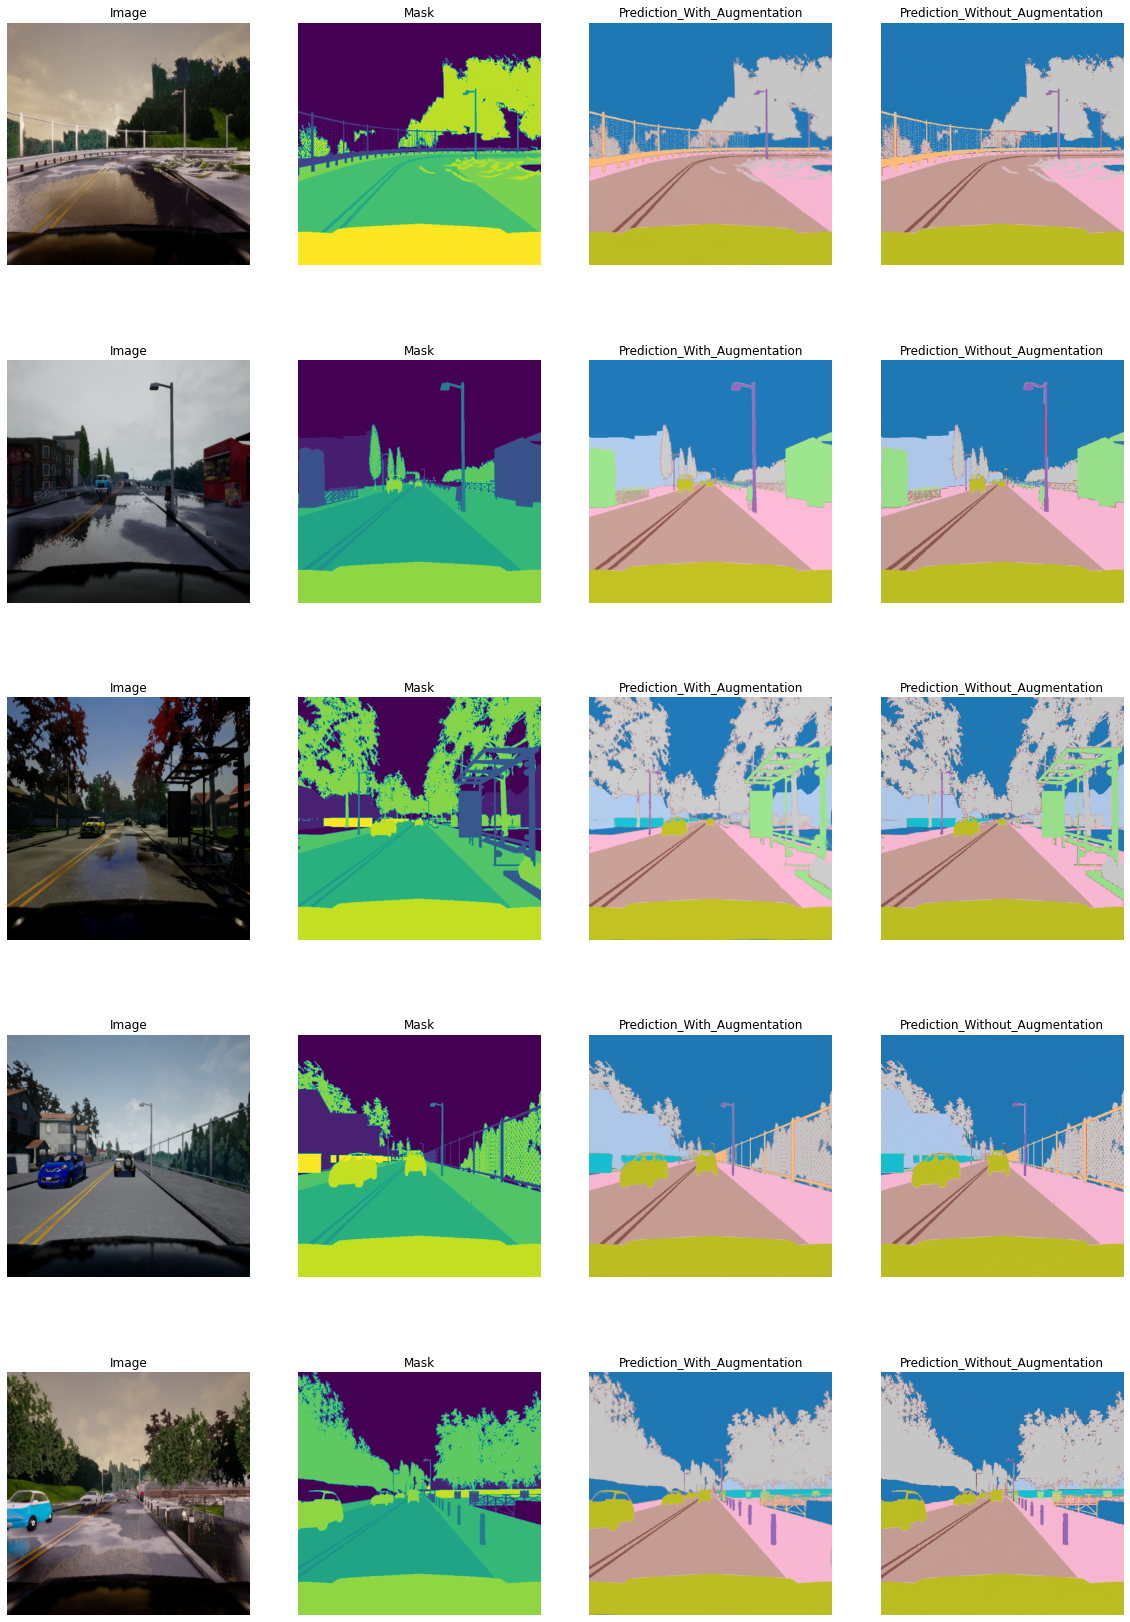

In [27]:
index = np.random.randint(0, len(images), 5)
fig, axes = plt.subplots(5, 4, figsize=(20, 30))

for i, ax in zip(index, axes):

    image, mask = load_data(images[i], masks[i])
    img = np.expand_dims(image, axis=0)
    img = img / 255.
    aug_pred = model_aug.predict(img)
    ord_pred = model_ord.predict(img)
    aug_mask = color_pred_mask(aug_pred)
    ord_mask = color_pred_mask(ord_pred)
    
    
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')
    
    ax[1].imshow(mask[:, :, 0])
    ax[1].set_title('Mask')
    ax[1].axis('off')
    
    
    ax[2].imshow(aug_mask)
    ax[2].set_title('Prediction_With_Augmentation')
    ax[2].axis('off')
    
    ax[3].imshow(ord_mask)
    ax[3].set_title('Prediction_Without_Augmentation')
    ax[3].axis('off')
    

plt.show()